# Importings

In [1178]:
import pandas as pd                                    # for data
import numpy as np                                     # for math
from lightgbm import LGBMRegressor                     # Validation model
from sklearn.metrics import mean_squared_error         # Regressortion metric
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   # for validation
from sklearn.preprocessing import LabelEncoder         # for encoding
import sklearn.manifold._t_sne as tsne                 # for t_sne
import seaborn as sns                     
from sklearn.model_selection import TimeSeriesSplit# for plotting
import matplotlib.pyplot as plt    
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import rankdata
import xgboost as xgb 
from sklearn.cluster import KMeans
train = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Train.csv') 
test = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Test.csv')
groups = train['ID']
test_id = test['ID_Zindi']
pd.options.display.max_columns = 200


In [1179]:
print(train.GT_NO2.value_counts())
print(train.GT_NO2.max())

GT_NO2
12.000000     797
13.000000     770
11.000000     767
10.000000     725
9.000000      724
             ... 
80.833333       1
113.225000      1
90.900000       1
86.375000       1
48.066667       1
Name: count, Length: 4245, dtype: int64
188.2333333


In [1180]:
max_lon = 9.216568750635945
max_lat = 45.51461188207373


def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    r = 6371
    return c * r
for df in (train,test): 
    df['distance'] = df.apply(lambda row: haversine(row['LON'], row['LAT'], max_lon, max_lat), axis=1)


In [1181]:
df

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,distance
0,ID_2MYNQS,1/1/19,PD03,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819,191.032888
1,ID_P4U5WU,1/1/19,TV03,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790,258.385986
2,ID_U4KWPK,1/1/19,X5561,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478,30.127211
3,ID_QGSNTZ,1/1/19,X5953,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006,75.592937
4,ID_GHSZ6K,1/1/19,X6701,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840,36.909828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,ID_GUSXU9,12/31/21,TV03,45.836941,12.510362,0.000000,282.58,-0.013364,0.000000,0.000032,0.000135,0.000103,13060.46860,258.385986
6572,ID_GMVEG1,12/31/21,X5561,45.582894,8.842165,0.000000,285.12,-0.412887,0.002098,0.000031,0.000201,0.000171,13056.11764,30.127211
6573,ID_GD6HNP,12/31/21,X5953,45.131947,10.015742,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.592937
6574,ID_J7YW1Y,12/31/21,X6701,45.186329,9.146666,0.000000,NaN,-1.025128,0.476947,0.000031,0.000751,NaN,13063.22260,36.909828


In [1182]:
train[train['GT_NO2'] > 100.524352].LON.mean()

np.float64(9.216568750635945)

In [1183]:
round(df['TropopausePressure'] * 0.00001,2)

0       0.14
1       0.14
2       0.14
3       0.14
4       0.14
        ... 
6571    0.13
6572    0.13
6573     NaN
6574    0.13
6575    0.13
Name: TropopausePressure, Length: 6576, dtype: float64

In [1184]:
def post_process(test_data,y,feature_to_mean='Month') -> int:
    test_data['target'] = y
    test_data['target_month'] = test_data[feature_to_mean].map(test_data[[feature_to_mean,'target']].groupby(feature_to_mean)['target'].mean())
    test_data.drop(columns='target',inplace=True)
    return test_data['target_month']

In [1185]:
for col in train.columns:
    print(col)    
    print(train[col].is_unique)
    print("___________________")

ID_Zindi
False
___________________
Date
False
___________________
ID
False
___________________
LAT
False
___________________
LON
False
___________________
Precipitation
False
___________________
LST
False
___________________
AAI
False
___________________
CloudFraction
False
___________________
NO2_strat
False
___________________
NO2_total
False
___________________
NO2_trop
False
___________________
TropopausePressure
False
___________________
GT_NO2
False
___________________
distance
False
___________________


In [1186]:
train.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2,distance
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000,86584.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051,78.323748
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838,72.501944
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000,2.709081
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000,26.854948
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000,47.020214
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000,121.181069
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333,262.923172


# Feature Engineering

In [1187]:
"""agg_funcs = ['mean', 'std', 'min', 'max'] 

def add_aggregated_features(dataset, columns, funcs):
    dataset = dataset.copy()
    for column in columns:
        agg_features_id = dataset.groupby('ID')[column].agg(funcs)
        agg_features_id.columns = [f'{column}_{agg_func}_agg_ID' for agg_func in funcs]
        dataset = dataset.merge(agg_features_id, on='ID')
    return dataset

# Apply the function to both train and test datasets
train = add_aggregated_features(train, columns_to_aggregate, agg_funcs)
test = add_aggregated_features(test, columns_to_aggregate, agg_funcs)"""

"agg_funcs = ['mean', 'std', 'min', 'max'] \n\ndef add_aggregated_features(dataset, columns, funcs):\n    dataset = dataset.copy()\n    for column in columns:\n        agg_features_id = dataset.groupby('ID')[column].agg(funcs)\n        agg_features_id.columns = [f'{column}_{agg_func}_agg_ID' for agg_func in funcs]\n        dataset = dataset.merge(agg_features_id, on='ID')\n    return dataset\n\n# Apply the function to both train and test datasets\ntrain = add_aggregated_features(train, columns_to_aggregate, agg_funcs)\ntest = add_aggregated_features(test, columns_to_aggregate, agg_funcs)"

In [1188]:
num_feats = train.select_dtypes(include=['float'])
kmeans = KMeans(n_clusters=2)

In [1189]:
"""train = train.sort_values('Date').reset_index(drop=True) 
test = test.sort_values('Date').reset_index(drop=True)
"""
for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    #df['target_month'] = df['Month'].map(df[['Month','GT_NO2']].groupby('Month')['GT_NO2'].mean())
    #df['Month'] = df['Date'].dt.is_month_start
    #df['Year'] =  df['Date'].dt.year
    #df.set_index(df['Date'],inplace=True)
    #df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df.drop(columns=['ID_Zindi','Date'],inplace=True)
    
#Lags
for df in(train,test): 
    #df['Precipitation_inter1'] = df['TropopausePressure'] + df['Precipitation']
    #df['Precipitation_log'] =  np.log(df['Precipitation'] + 1e-9)
    df['CloudFraction_diff'] = df['CloudFraction'] / df['NO2_strat']
    df['CloudFraction_diff2'] = df['CloudFraction'] / df['NO2_total']
    #['Precipitation_fractional'] = df['Precipitation'] * 0.00001
    #df['TropopausePressure_fractional'] = round(df['TropopausePressure'] * 0.00001,2)
    #df['cluster'] = kmeans.fit_transform(df[['LAT', 'LON']])
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_strat']
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_total']

#for df in(train,test): 
    #Rolling (Moving Average)
    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()
#statsitics of similar variables

"""def MeanSd(feature1, feature2):
    for dataset in (train,test):
        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)
        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)

MeanSd('NO2_trop','NO2_total')
MeanSd('LON','LAT')"""

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_30180/2501110604.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_30180/2501110604.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


'def MeanSd(feature1, feature2):\n    for dataset in (train,test):\n        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)\n        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)\n\nMeanSd(\'NO2_trop\',\'NO2_total\')\nMeanSd(\'LON\',\'LAT\')'

In [1190]:
#for df in(train,test): 
    #df['LST_mean_60'] = df['LST'].rolling(60).mean()
    #df['Prec_mean_60'] = df['Precipitation'].rolling(60).mean()
    #df['AII_mean'] = df['AAI'].rolling(60).mean()
    #df['no2_total'] = df['NO2_total'].rolling(60).min()

    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()


def rolling(feature):
    for dataset in (train,test):
        #dataset[f"{feature}_rolling_mean_60"] = dataset[feature].rolling(60).mean()
        dataset[f"{feature}_rolling_max_60"] = dataset[feature].rolling(60).max()
        #dataset[f"{feature}_rolling_min_60"] = dataset[feature].rolling(60).min()


rolling('NO2_trop')
rolling('NO2_total')
rolling('TropopausePressure')
rolling('CloudFraction')
#rolling('AAI')
#rolling('LST')
rolling('Precipitation')

# Missing Values & Encoding

In [1191]:
groups = train['ID']
for df in(train,test):
    df.drop(columns=['ID'], axis=1,inplace=True)

In [1192]:
le = LabelEncoder()
for df in(train,test): 
    for col in df.columns: 
        if df[col].dtype == 'object': 
            df[col] = le.fit_transform(df[col])

In [1193]:
"""from sklearn.impute import KNNImputer

combined = pd.concat([train, test], keys=['train', 'test'])
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(combined)
imputed_df = pd.DataFrame(imputed_data, columns=combined.columns, index=combined.index)

train = imputed_df.loc['train'].reset_index(drop=True)
train = imputed_df.loc['test'].reset_index(drop=True)"""

"from sklearn.impute import KNNImputer\n\ncombined = pd.concat([train, test], keys=['train', 'test'])\nimputer = KNNImputer(n_neighbors=2)\nimputed_data = imputer.fit_transform(combined)\nimputed_df = pd.DataFrame(imputed_data, columns=combined.columns, index=combined.index)\n\ntrain = imputed_df.loc['train'].reset_index(drop=True)\ntrain = imputed_df.loc['test'].reset_index(drop=True)"

# CV and Modeling

In [1194]:
#groups = train['ID']
model =  LGBMRegressor(random_state=7)
n_splits = 5
n = train['GT_NO2'].count()
num_bins = int(1 + np.log2(n))
#train['GT_NO2_bins'] = pd.cut(train['GT_NO2'], bins=num_bins, labels=False)
#test['GT_NO2_bins'] = pd.cut(test['GT_NO2'], bins=num_bins, labels=False)

In [1199]:
model = LGBMRegressor(random_state=7)
n_splits = 4
cv = GroupKFold(n_splits=n_splits)

def validate(trainset, testset, target_col):

    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    print('score:', score)
    
    return score
stds = []
rmse = []

for train_idx, test_idx in cv.split(train.drop(columns='GT_NO2'), train['GT_NO2'], groups=groups):
    train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
    stds.append(test_v['GT_NO2'].std())
    rmse.append(validate(train_v, test_v, 'GT_NO2'))

print('RMSE:', np.array(rmse).mean())
print('RMSE std:', np.array(rmse).std())
print('Standard Deviations:', stds)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3993
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 19
[LightGBM] [Info] Start training from score 24.434701
std: 14.844616530580991
score: 9.153067103033932


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3995
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 19
[LightGBM] [Info] Start training from score 22.752866
std: 19.09580192108185
score: 11.518191765537411


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3995
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 19
[LightGBM] [Info] Start training from score 22.615852
std: 18.147840185499298
score: 13.487397481850756


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3996
[LightGBM] [Info] Number of data points in the train set: 65760, number of used features: 19
[LightGBM] [Info] Start training from score 23.199636
std: 15.385929166349635
score: 12.230488293384006
RMSE: 11.597286160951526
RMSE std: 1.5774923512003132
Standard Deviations: [np.float64(14.844616530580993), np.float64(19.09580192108185), np.float64(18.147840185499298), np.float64(15.385929166349635)]


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1196]:
#12.246931687286574
#12.235259341356834
#12.231869616518921
#12.126333476852636
#11.728753513719479
#11.724263538742687
#11.728753513719479 
#11.711277895239192
#11.694341231865433
#11.671982426722977
#11.642227859275334 without the mean - with the custamized means of rolling
#11.314985626750522 
#11.314985626750522
#11.312413659993586
#11.135932399851725 
#11.728753513719479 best so far features = ['LAT', 'Month','NO2_trop_rolling_max_60','NO2_total_rolling_max_60','TropopausePressure_rolling_max_60','CloudFraction_rolling_max_60','Precipitation_rolling_max_60']

In [1197]:
hshsd

NameError: name 'hshsd' is not defined

In [ ]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y = model.predict(test)
smaple = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/SampleSubmission.csv')
smaple['GT_NO2'] = post_process(test,y)
smaple.to_csv('submissionpost.csv',index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4651
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 21
[LightGBM] [Info] Start training from score 23.250548


In [1200]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
#sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
#sub_df.to_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/submissions/submission11343376784034582.csv', index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4054
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 19
[LightGBM] [Info] Start training from score 23.250548


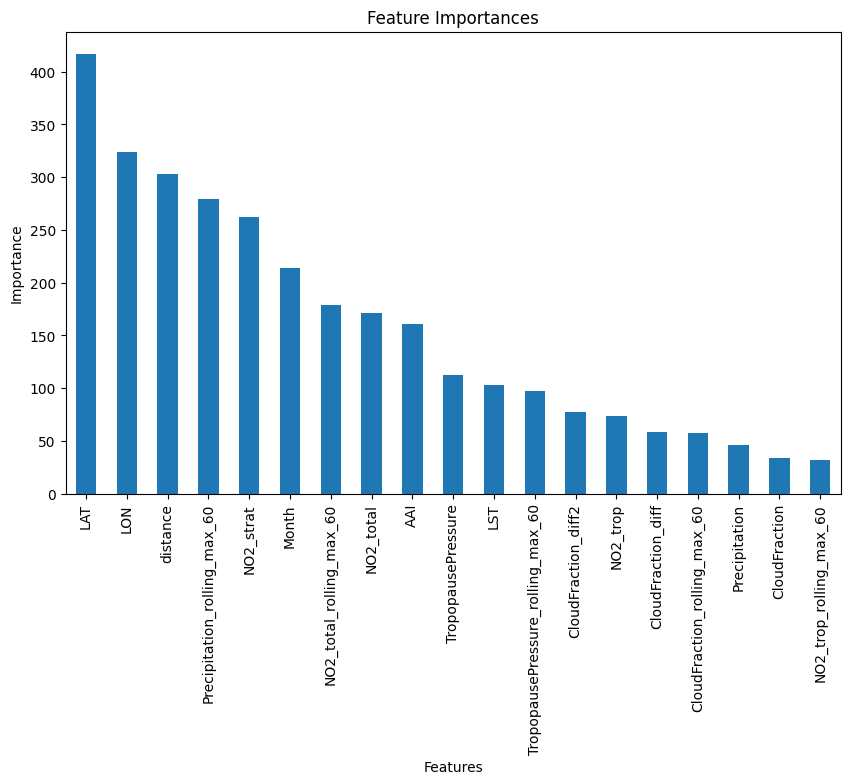

In [1201]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
fi

,Feature,importances
0,LAT,527
1,LON,521
6,NO2_strat,292
15,Precipitation_rolling_max_60,264
10,Month,220
7,NO2_total,189
12,NO2_total_rolling_max_60,170
4,AAI,169
9,TropopausePressure,109
5,CloudFraction,107


In [ ]:
names

['LAT',
 'LON',
 'Precipitation',
 'LST',
 'AAI',
 'CloudFraction',
 'NO2_strat',
 'NO2_total',
 'NO2_trop',
 'TropopausePressure',
 'Month',
 'NO2_trop_rolling_max_60',
 'NO2_total_rolling_max_60',
 'TropopausePressure_rolling_max_60',
 'CloudFraction_rolling_max_60',
 'Precipitation_rolling_max_60']